# Testing the CNN Model
**Author:** Sandy Tam
<br>

**Dataset:** Kaggle - Cat Breeds Dataset

This notebook implements a CNN and compares the perfomance of different kernel sizes. The CNN will proceed with training in another notebook (cnn.ipynb) using the best kernel size found.

**Objectives:**
1.  Define a CNN with Batch Normalization and Dropout layers.
2.  Compare the performance of different kernel sizes (e.g., 3x3, 5x5, 7x7).
3.  Select the best kernel size and visualize Training vs. Validation loss and accuracy.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader
import time, sys
import gc
import json
from datetime import datetime

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------- UNCOMMENT IF USING GPU MEMORY --------
# from torch.cuda.amp import autocast, GradScaler
# torch.cuda.empty_cache()
# gc.collect()

# torch.backends.cudnn.benchmark = True

# print(f'Using device: {device}')
# print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
# print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
# print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

In [10]:
def save_checkpoint(model, optimizer, scheduler, epoch, history, kernel_size, 
                   checkpoint_dir='checkpoints', is_best=False):
    """Save training checkpoint."""
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.cuda.empty_cache()
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'history': history,
        'kernel_size': kernel_size,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'gpu_memory_peak': torch.cuda.max_memory_allocated(0) / 1e9
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_k{kernel_size}_epoch{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved: {checkpoint_path}")
    
    if is_best:
        best_path = os.path.join(checkpoint_dir, f'best_model_k{kernel_size}.pt')
        torch.save(checkpoint, best_path)
        print(f"Best model saved!")
    
    latest_path = os.path.join(checkpoint_dir, f'latest_k{kernel_size}.pt')
    torch.save(checkpoint, latest_path)
    
    return checkpoint_path


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None, device='cuda'):
    """Load checkpoint and resume training."""
    if not os.path.exists(checkpoint_path):
        return 0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"\nLoading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint.get('scheduler_state_dict'):
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    print(f"Resuming from epoch {start_epoch}")
    if history['val_acc']:
        print(f"  Best val acc so far: {max(history['val_acc']):.2f}%\n")
    
    return start_epoch, history


def find_latest_checkpoint(kernel_size, checkpoint_dir='checkpoints'):
    """Find the most recent checkpoint."""
    latest_path = os.path.join(checkpoint_dir, f'latest_k{kernel_size}.pt')
    return latest_path if os.path.exists(latest_path) else None


def list_checkpoints(checkpoint_dir='checkpoints'):
    """List all checkpoints."""
    if not os.path.exists(checkpoint_dir):
        print("No checkpoints found")
        return
    
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])
    if not checkpoints:
        print("No checkpoints found")
        return
    
    print(f"\n{'='*70}")
    print(f"Available Checkpoints ({len(checkpoints)} files)")
    print(f"{'='*70}")
    
    for cp in checkpoints:
        cp_path = os.path.join(checkpoint_dir, cp)
        try:
            checkpoint = torch.load(cp_path, map_location='cpu')
            best_val = max(checkpoint['history']['val_acc']) if checkpoint['history']['val_acc'] else 0
            print(f"{cp}: Epoch {checkpoint['epoch']} | Val Acc {best_val:.2f}%")
        except:
            print(f"{cp} (unable to load)")
    print(f"{'='*70}\n")


print("Checkpoint system loaded!")

Checkpoint system loaded!


## 1. Data Loading

In [11]:
# hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10  
TARGET_SIZE = (224, 224)

# data directories
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

# transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    )
])

# load the datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

# data loaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,              
    pin_memory=True,         
    prefetch_factor=2  
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,           
    pin_memory=True          
)
print(f'Classes: {len(train_dataset.classes)}')
print(f'Training samples: {len(train_dataset)}')
print(f'Testing samples: {len(test_dataset)}')
print(f'Batches per epoch: {len(train_loader)}')
print(f'Batch size: {BATCH_SIZE}')

Classes: 66
Training samples: 18054
Testing samples: 2257
Batches per epoch: 565
Batch size: 32


## 2. Model Definition
Includes batch normalization and dropout layers to avoid overfitting.

In [12]:
class CatBreedCNN(nn.Module):
    def __init__(self, num_classes=66, kernel_size=3):
        super(CatBreedCNN, self).__init__()
        
        padding = kernel_size // 2
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size, padding=padding)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Block 4
        self.conv7 = nn.Conv2d(256, 512, kernel_size, padding=padding)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size, padding=padding)
        self.bn8 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        # Adaptive pooling to handle any input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Block 2
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Block 3
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        
        # Block 4
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

## 3. Training Function
Validation tracking during model training with checkpoint saving.

In [13]:
def train_and_validate_with_checkpoints(model, train_loader, val_loader, criterion, 
                                        optimizer, scheduler=None, num_epochs=10, 
                                        device='cuda', kernel_size=3, 
                                        checkpoint_dir='checkpoints',
                                        resume_from=None, use_mixed_precision=True):
    """Crash-resistant training with automatic checkpointing."""
    
    model = model.to(device)
    
    # auto-resume from checkpoint
    if resume_from is None:
        resume_from = find_latest_checkpoint(kernel_size, checkpoint_dir)
    
    if resume_from:
        # load checkpoint with map_location to ensure everything goes to correct device
        print(f"\nLoading checkpoint: {resume_from}")
        checkpoint = torch.load(resume_from, map_location=device)
        
        # load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model = model.to(device)
        
        # load optimizer state
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            # move optimizer states to device
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)
        
        # load scheduler state
        if scheduler and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_acc = max(history['val_acc']) if history['val_acc'] else 0.0
        
        print(f"Resuming from epoch {start_epoch}")
        if history['val_acc']:
            print(f"  Best val acc so far: {best_val_acc:.2f}%\n")
    else:
        start_epoch = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        best_val_acc = 0.0
        print(f"Starting fresh training")
    
    # ensure model is in training mode and on correct device
    model = model.to(device)
    
    # initialize scaler
    scaler = GradScaler() if use_mixed_precision else None
    
    print(f"\n{'='*70}")
    print(f"Kernel {kernel_size} | Epochs {start_epoch+1}-{num_epochs} | Mixed Precision: {use_mixed_precision}")
    print(f"Device: {next(model.parameters()).device}")  # verify model device
    print(f"{'='*70}\n")
    
    try:
        for epoch in range(start_epoch, num_epochs):
            torch.cuda.empty_cache()
            gc.collect()
            
            epoch_start = time.time()
            
            # TRAINING
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                optimizer.zero_grad(set_to_none=True)
                
                if use_mixed_precision:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                if (batch_idx + 1) % 20 == 0:
                    print(f"Epoch {epoch+1} Train: [{batch_idx+1}/{len(train_loader)}]", end='\r')
            
            avg_train_loss = train_loss / len(train_loader)
            avg_train_acc = 100 * train_correct / train_total
            
            torch.cuda.empty_cache()
            
            # VALIDATION
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    
                    if use_mixed_precision:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = 100 * val_correct / val_total
            
            if scheduler:
                scheduler.step(avg_val_acc)
            
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(avg_train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(avg_val_acc)
            
            is_best = avg_val_acc > best_val_acc
            if is_best:
                best_val_acc = avg_val_acc
            
            # SAVE CHECKPOINT
            save_checkpoint(model, optimizer, scheduler, epoch, history, kernel_size, checkpoint_dir, is_best)
            
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time/60:.1f}min")
            print(f"Train: Loss={avg_train_loss:.4f} Acc={avg_train_acc:.2f}%")
            print(f"Valid: Loss={avg_val_loss:.4f} Acc={avg_val_acc:.2f}%")
            print(f"Best: {best_val_acc:.2f}%\n")
            
            torch.cuda.reset_peak_memory_stats()
        
        print(f"\nTraining complete! Best: {best_val_acc:.2f}%")
        
    except Exception as e:
        print(f"\n Error: {str(e)}")
        print(f" Checkpoint saved - restart kernel and run again to resume!")
        raise e
    
    return history

print(" Training function loaded!")

 Training function loaded!


## 4. Experiments: Kernel Sizes
Comparing Kernel Sizes: 3, 5, and 7.

In [14]:
kernel_sizes = [3, 5, 7]
results = {}

# check existing checkpoints
list_checkpoints()

for exp_idx, k in enumerate(kernel_sizes, 1):
    print(f"\n{'#'*70}")
    print(f"# EXPERIMENT {exp_idx}/3: Kernel Size {k}")
    print(f"{'#'*70}")
    
    # check if already complete
    existing = find_latest_checkpoint(kernel_size=k)
    if existing:
        temp_model = CatBreedCNN(kernel_size=k)
        start_ep, temp_hist = load_checkpoint(existing, temp_model, device=device)
        
        if start_ep >= NUM_EPOCHS:
            print(f"Already complete!")
            results[k] = temp_hist
            continue
    
    # train
    model = CatBreedCNN(kernel_size=k)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()
    
    try:
        history = train_and_validate_with_checkpoints(
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=NUM_EPOCHS,
            device=device,
            kernel_size=k,
            use_mixed_precision=True
        )
        
        results[k] = history
        
        # cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()
        
        if exp_idx < len(kernel_sizes):
            print("Cooling GPU for 30s...")
            time.sleep(30)
            
    except Exception as e:
        print(f"Experiment {exp_idx} failed: {e}")
        print("Progress saved! Restart kernel and run again.")
        break

# summary
if results:
    print(f"\n{'='*70}")
    print("FINAL RESULTS")
    print(f"{'='*70}")
    for k in sorted(results.keys()):
        best = max(results[k]['val_acc']) if results[k]['val_acc'] else 0
        print(f"Kernel {k}: {best:.2f}%")
    print(f"{'='*70}")

print("\nAll experiments complete!")


Available Checkpoints (6 files)


C:\Users\hurri\AppData\Local\Temp\ipykernel_30332\1563560719.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cp_path, map_location='cpu')


best_model_k3.pt: Epoch 6 | Val Acc 20.38%
best_model_k5.pt: Epoch 9 | Val Acc 22.37%
best_model_k7.pt: Epoch 9 | Val Acc 19.72%
latest_k3.pt: Epoch 9 | Val Acc 20.38%
latest_k5.pt: Epoch 9 | Val Acc 22.37%
latest_k7.pt: Epoch 9 | Val Acc 19.72%


######################################################################
# EXPERIMENT 1/3: Kernel Size 3
######################################################################

Loading checkpoint: checkpoints\latest_k3.pt


C:\Users\hurri\AppData\Local\Temp\ipykernel_30332\1563560719.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Resuming from epoch 10
  Best val acc so far: 20.38%

Already complete!

######################################################################
# EXPERIMENT 2/3: Kernel Size 5
######################################################################

Loading checkpoint: checkpoints\latest_k5.pt
Resuming from epoch 10
  Best val acc so far: 22.37%

Already complete!

######################################################################
# EXPERIMENT 3/3: Kernel Size 7
######################################################################

Loading checkpoint: checkpoints\latest_k7.pt
Resuming from epoch 10
  Best val acc so far: 19.72%

Already complete!

FINAL RESULTS
Kernel 3: 20.38%
Kernel 5: 22.37%
Kernel 7: 19.72%

All experiments complete!


## 5. Results & Visualization

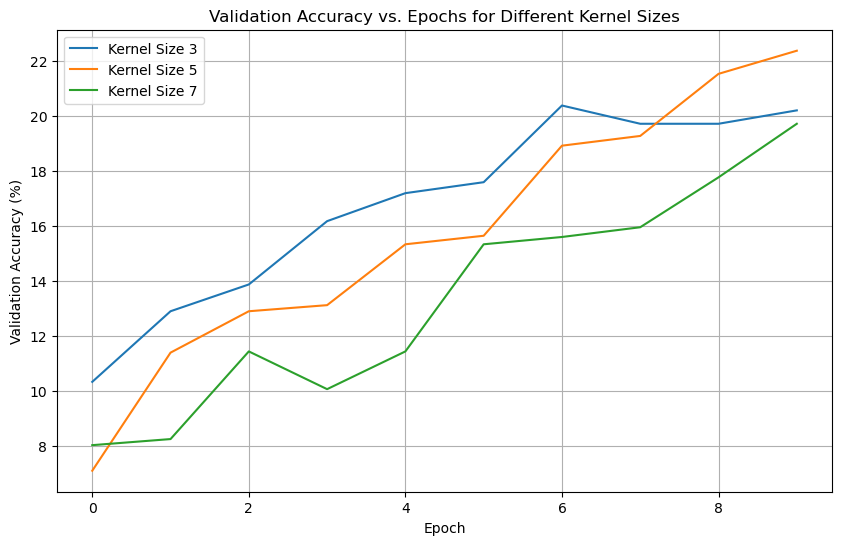


Best Kernel Size based on max validation accuracy: 5


In [15]:
# comparing kernel sizes based on validation accuracy
plt.figure(figsize=(10, 6))
for k in kernel_sizes:
    plt.plot(results[k]['val_acc'], label=f'Kernel Size {k}')
plt.title('Validation Accuracy vs. Epochs for Different Kernel Sizes')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# find best kernel size
best_k = max(results, key=lambda k: max(results[k]['val_acc']))
print(f"\nBest Kernel Size based on max validation accuracy: {best_k}")

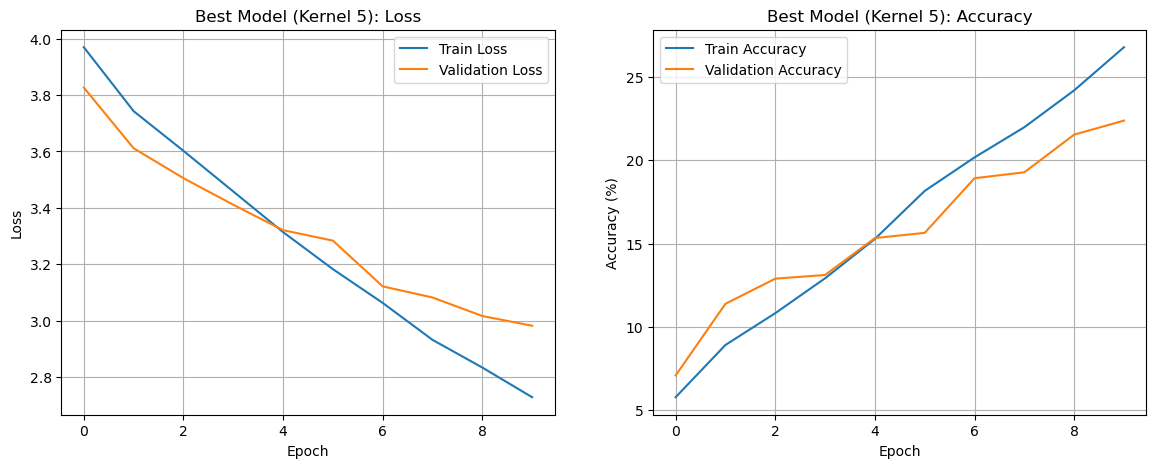

In [16]:
# plot best model loss and accuracy
best_history = results[best_k]

plt.figure(figsize=(14, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title(f'Best Model (Kernel {best_k}): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history['train_acc'], label='Train Accuracy')
plt.plot(best_history['val_acc'], label='Validation Accuracy')
plt.title(f'Best Model (Kernel {best_k}): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()